In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

Let's say our population is finite and we know it: a uniform over the numbers 0 to 10,000 (inclusive). (Note: You would never need statistical inference if you knew the whole population; we're just creating a playground to try out techniques.)

In [2]:
population = np.arange(10001)

We might want to know the population mean. In this case, we do!

In [3]:
np.mean(population)

5000.0

But if we only had a sample, then we would perhaps estimate (guess) that the sample mean is a reasonable approximation for the true mean.

In [15]:
sample_100 = np.random.choice(population, size=100, replace=False)
np.mean(sample_100)

5315.3199999999997

In this case, the estimator is the function `np.mean` and the parameter is 5000. The estimate is close, but it's wrong.

### Sample variance estimator for the variance of the sample mean

Here's an impractical but effective method for estimating the variance of an estimator `f`.

80760.988040640194

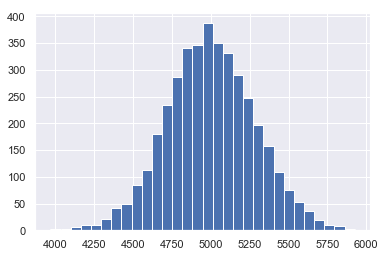

In [20]:
def var_estimate(f, pop, m=4000, n=100):
    """Estimate the variance of estimator f by the empirical variance.
    
    f: A function of a sample
    pop: An array representing the whole population
    m, n: Use m samples of size n to estimate the variance
    """
    estimates = []
    for j in range(m):
        sample = np.random.choice(pop, size=n, replace=False)
        estimates.append(f(sample))
    estimates = np.array(estimates)
    plt.hist(estimates, bins=30)
    return np.mean((estimates - np.mean(estimates))**2) # same as np.var(estimates)

var_estimate(np.mean, population)

19767.913412479335

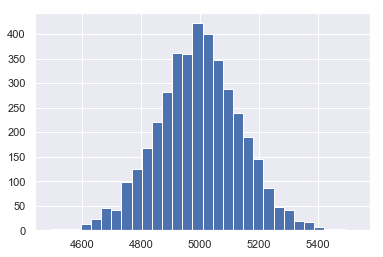

In [21]:
var_estimate(np.mean, population, n=400)

4535.3246194195399

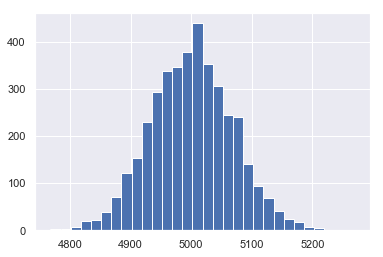

In [22]:
var_estimate(np.mean, population, n=1600)

If we know the variance of the sampling distribution and we know that the sampling distribution is approximately normal, then we know how far off a single estimate is likely to be. About 95% of estimates will be within 2 standard deviations of the mean, so for 95% of samples, the estimate will be off by the following (or less).

566.8811164958042

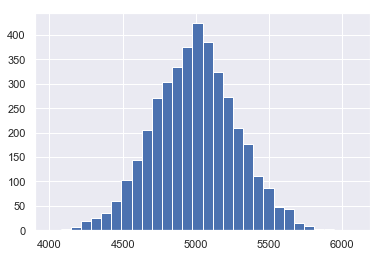

In [8]:
2 * np.sqrt(var_estimate(np.mean, population))

Unfortunately, estimating the variance required repeated sampling from the population.

### Bootstrap estimator for the variance of the sample mean

Instead, we can estimate the variance using bootstrap resampling.

77877.09221099394

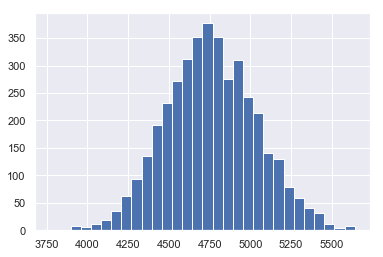

In [9]:
def bootstrap_var_estimate(f, sample, m=4000):
    """Estimate the variance of estimator f by the empirical variance.
    
    f: A function of a sample
    sample: An array representing a sample of size n
    m: Use m samples of size n to estimate the variance
    """
    estimates = []
    n = len(sample)
    for j in range(m):
        resample = np.random.choice(sample, size=n, replace=True)
        estimates.append(f(resample))
    estimates = np.array(estimates)
    plt.hist(estimates, bins=30)
    return np.mean((estimates - np.mean(estimates))**2) # same as np.var(estimates)

bootstrap_var_estimate(np.mean, sample_100)

21873.950217289403

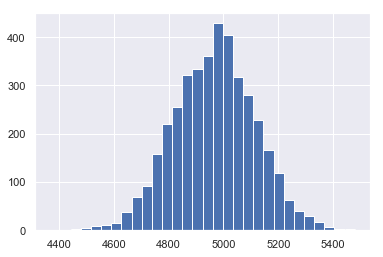

In [10]:
sample_400 = np.random.choice(population, 400, replace=False)
bootstrap_var_estimate(np.mean, sample_400)

5056.719101624659

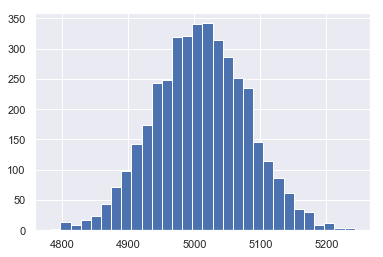

In [11]:
sample_1600 = np.random.choice(population, 1600, replace=False)
bootstrap_var_estimate(np.mean, sample_1600)

### Bootstrap confidence interval

In [26]:
def ci(sample, estimator, confidence=95, m=1000):
    """Compute a confidence interval for an estimator.
    
    sample: A DataFrame or Series
    estimator: A function from a sample DataFrame to an estimate (number)
    """
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    estimates = np.array(estimates)
    slack = 100 - confidence
    lower = np.percentile(estimates, slack/2)
    upper = np.percentile(estimates, 100 - slack/2)
    return (lower, upper)

s_100 = pd.Series(sample_100)
ci(s_100, np.mean)

(4759.0887499999999, 5812.5829999999996)

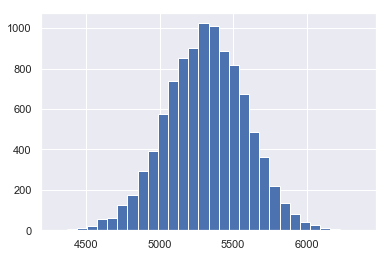

In [38]:
def bootstrap_dist(sample, estimator, m=10000):
    estimates = []
    n = sample.shape[0]
    for j in range(m):
        resample = sample.sample(n, replace=True)
        estimates.append(estimator(resample))
    plt.hist(estimates, bins=30)
    
bootstrap_dist(s_100, np.mean)

In [34]:
mean_ints = [ci(pd.Series(np.random.choice(population, 100)), np.mean) for _ in range(100)]

93

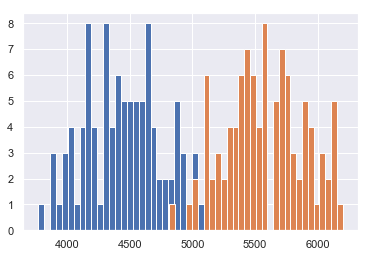

In [35]:
plt.hist([v[0] for v in mean_ints], bins=30);
plt.hist([v[1] for v in mean_ints], bins=30);
sum([v[0] <= 5000 <= v[1] for v in mean_ints])

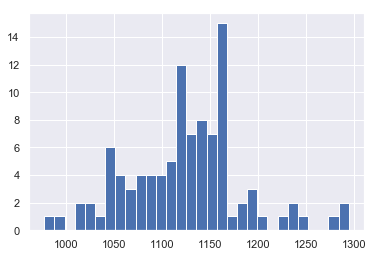

In [36]:
def width(interval):
    return interval[1] - interval[0]

plt.hist([width(v) for v in mean_ints], bins=30);

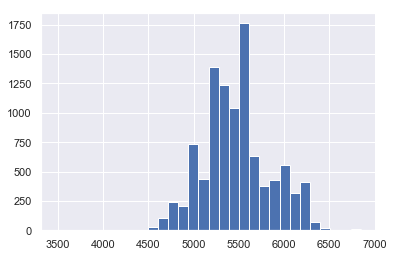

In [39]:
bootstrap_dist(s_100, np.median)

### Median

In [40]:
ci(s_100, np.median)

(4806.6000000000004, 6236.5)

In [42]:
width(ci(s_100, np.median))

1458.3874999999998

In [43]:
median_ints = [ci(pd.Series(np.random.choice(population, 100)), np.median) for _ in range(100)]

In [44]:
sum([v[0] <= 5000 <= v[1] for v in median_ints])

97

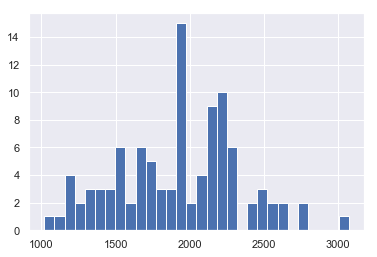

In [45]:
plt.hist([width(v) for v in median_ints], bins=30);

### Standard Deviation

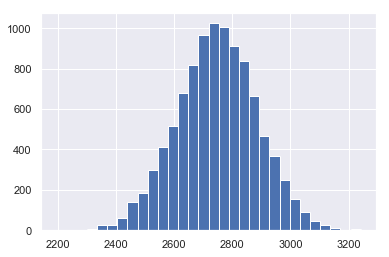

In [46]:
bootstrap_dist(s_100, np.std)

In [47]:
ci(s_100, np.std)

(2468.7106248223736, 3002.9678076297846)

In [48]:
np.std(population)

2887.0400066504103

In [49]:
std_ints = [ci(pd.Series(np.random.choice(population, 100)), np.std) for _ in range(100)]

In [50]:
sum([v[0] <= np.std(population) <= v[1] for v in std_ints])

93

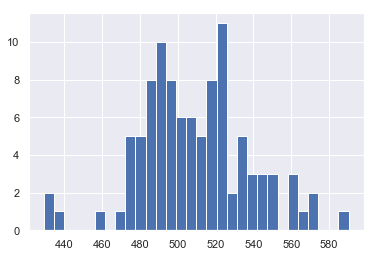

In [51]:
plt.hist([width(v) for v in std_ints], bins=30);

### 99th Percentile

In [52]:
p99 = lambda a: np.percentile(a, 99)
p99(population)

9900.0

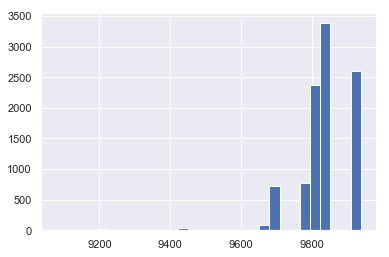

In [53]:
bootstrap_dist(s_100, p99)

In [54]:
ci(s_100, p99)

(9688.1599999999999, 9938.0)

In [55]:
p99_ints = [ci(pd.Series(np.random.choice(population, 100)), p99) for _ in range(100)]

In [56]:
sum([v[0] <= p99(population) <= v[1] for v in p99_ints])

70

#### Max

In [57]:
ci(s_100, max)

(9794.0, 9938.0)

In [58]:
max_ints = [ci(pd.Series(np.random.choice(population, 100)), max) for _ in range(100)]

In [59]:
sum([v[0] <= max(population) <= v[1] for v in max_ints])

0

### Classifier accuracy

In [37]:
import sklearn.datasets
data_dict = sklearn.datasets.load_breast_cancer()
cancer = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
cancer['bias'] = 1.0
# Target data_dict['target'] = 0 is malignant; 1 is benign
cancer['malignant'] = 1 - data_dict['target']
cancer.iloc[0]

mean radius                  17.990000
mean texture                 10.380000
mean perimeter              122.800000
mean area                  1001.000000
mean smoothness               0.118400
mean compactness              0.277600
mean concavity                0.300100
mean concave points           0.147100
mean symmetry                 0.241900
mean fractal dimension        0.078710
radius error                  1.095000
texture error                 0.905300
perimeter error               8.589000
area error                  153.400000
smoothness error              0.006399
compactness error             0.049040
concavity error               0.053730
concave points error          0.015870
symmetry error                0.030030
fractal dimension error       0.006193
worst radius                 25.380000
worst texture                17.330000
worst perimeter             184.600000
worst area                 2019.000000
worst smoothness              0.162200
worst compactness        

In [38]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cancer, test_size=0.25, random_state=100)
x_train = train.drop('malignant', axis=1).values
y_train = train['malignant'].values
x_test = test.drop('malignant', axis=1).values
y_test = test['malignant'].values

print("Training Data Size: ", len(train))
print("Test Data Size: ", len(test))

Training Data Size:  426
Test Data Size:  143


In [39]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=False, C=1e-5, solver='lbfgs')
model.fit(x_train, y_train)
correct = model.predict(x_test) == y_test
np.mean(correct)

0.9300699300699301

In [40]:
ci(pd.Series(correct), np.mean)

(0.8881118881118881, 0.965034965034965)

### Linear regression parameter estimation

In [41]:
data_dict = sklearn.datasets.load_boston()
print(data_dict['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [42]:
house = pd.DataFrame(data_dict['data'], columns=data_dict['feature_names'])
house['MEDV'] = data_dict['target']
house.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


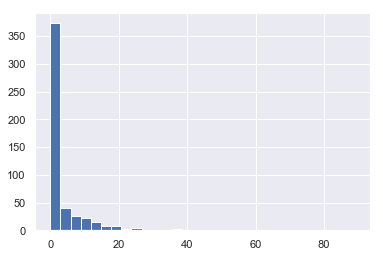

In [43]:
plt.hist(house['CRIM'], bins=30);

In [51]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(house.iloc[:,:-1].values, 
                             house.iloc[:,-1].values)
reg.coef_

array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
       -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
        3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
       -5.24758378e-01])

In [53]:
def crime_rate_slope(t):
    reg = LinearRegression().fit(t.iloc[:,:-1].values, 
                                 t.iloc[:,-1].values)
    return reg.coef_[0]

ci(house, crime_rate_slope)

(-0.15931362398873444, -0.029577809582398144)